In [61]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import statistics
import sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from utils import return_replicates, ause
from utils import permutation_test_ause
from data_loader import data_loader
import itertools

In [6]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [8]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [9]:
model = BaggingClassifier(base_estimator=LogisticRegression(C= 0.9, max_iter=1000), n_estimators=30, max_samples=1.0, max_features=1.0, bootstrap=True,
             bootstrap_features=True, oob_score=True, warm_start=False).fit(X, y)

In [10]:
def ensemble(X, y, base_estimator=LogisticRegression(C= 0.9, max_iter=1000), n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True,
             bootstrap_features=True, oob_score=True, warm_start=False, **kwargs):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    model = BaggingClassifier(base_estimator=base_estimator, n_estimators=n_estimators,
                              max_samples=max_samples, max_features=max_features, 
                              bootstrap=bootstrap, bootstrap_features=bootstrap_features,
                              oob_score=bootstrap_features)
    
    
    model.fit(x_train, y_train)
    
    y_preds = model.predict(x_test)
    y_probs = model.predict_proba(x_test)

    probs = pd.DataFrame()
    i = 1
    for mod in model.estimators_:
        probs1 = mod.predict_proba(x_test)[:, 1] # probabilities of input being classified as 1
        probs[f'mod{i}'] = probs1
        i+=1
    
    var_predictions = probs.var(axis=1).ravel()
    #var_models = probs.var(axis=0)
    
    return model, y_probs, probs, var_predictions

In [11]:
model, y_probs, probs, var_predictions = ensemble(X, y)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\b

In [12]:
len(y_probs)

192

In [13]:
var_predictions[:2] # variance of output of estimators for each prediction.

array([0.14465896, 0.18544288])

In [14]:
y_probs[:,1][:10]

array([0.09872708, 0.1842695 , 0.7289385 , 0.1779286 , 0.29103734,
       0.6722789 , 0.08938625, 0.08755135, 0.74997074, 0.86732263])

In [15]:
var_predictions.ravel()

array([0.14465896, 0.18544288, 0.10470527, 0.21626092, 0.19726931,
       0.13605565, 0.14363898, 0.20243662, 0.00658425, 0.06482151,
       0.19031687, 0.10878982, 0.18810929, 0.04961639, 0.08303056,
       0.15604876, 0.15922678, 0.14698226, 0.15958891, 0.12605311,
       0.01014158, 0.14133316, 0.21100601, 0.20622572, 0.16461341,
       0.12032707, 0.17635741, 0.07507481, 0.23364671, 0.08309668,
       0.10972235, 0.13732979, 0.20379323, 0.13114423, 0.13697522,
       0.20994842, 0.06724878, 0.14842976, 0.05754179, 0.195158  ,
       0.17715823, 0.21644428, 0.22715401, 0.20208924, 0.1142494 ,
       0.18835092, 0.18860457, 0.1726556 , 0.19701105, 0.13946646,
       0.20503117, 0.00866342, 0.19517864, 0.18254814, 0.07500841,
       0.00137901, 0.07615376, 0.09420172, 0.07073051, 0.14969441,
       0.00730819, 0.10001007, 0.16755389, 0.15540952, 0.17074247,
       0.24129664, 0.15859094, 0.13354908, 0.13617278, 0.07141623,
       0.15739999, 0.01134274, 0.1472553 , 0.10094131, 0.23650

In [16]:
ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())

(0.4831040898718556,
 array([0.        , 0.0124842 , 0.02296798, 0.02771081, 0.03327367,
        0.0473348 , 0.05547476, 0.06336687, 0.07728929, 0.09205294,
        0.09322629, 0.10897998, 0.11563059, 0.12332429, 0.13823491,
        0.15451494, 0.16974677, 0.18653296, 0.20052214, 0.20811006,
        0.21896545, 0.23211654, 0.243111  , 0.25200652, 0.26490411,
        0.26342912, 0.2769787 , 0.28811147, 0.30564827, 0.32222716,
        0.3326692 , 0.34202659, 0.35818917, 0.36651327, 0.37240994,
        0.38158967, 0.37992432, 0.38394569, 0.39218591, 0.41003278,
        0.41543083, 0.42260214, 0.44052091, 0.45131847, 0.46879108,
        0.48753005, 0.49748035, 0.50744704, 0.52354472, 0.522578  ,
        0.52924032, 0.53672311, 0.53738728, 0.5348356 , 0.53990436,
        0.54296569, 0.56071767, 0.57110867, 0.56377536, 0.56542425,
        0.56820219, 0.56203048, 0.56720516, 0.57046278, 0.57495695,
        0.59376836, 0.5844172 , 0.59965547, 0.614147  , 0.63303895,
        0.63118627, 0.65229

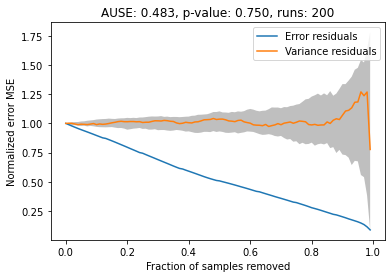

In [83]:
permutation_test_ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())

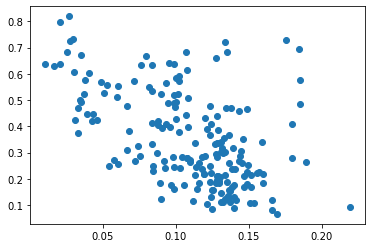

In [12]:
plt.scatter(var_predictions, y_probs[:,1])


# colors = plt.cm.get_cmap("Dark2")

# plt.hist(
#     y_probs[:,1],
#     range=(0, 1),
#     bins=10)

In [18]:
def expected_calibration_error(y_true, y_pred, num_bins=15):
    "y_preds should contain list of probabilities. More bins reduce the bias, but increase the variance "
    pred_y = np.argmax(y_pred, axis=-1)
    correct = (pred_y == y_true).astype(np.float32)
    prob_y = np.max(y_pred, axis=-1)

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    bins = np.digitize(prob_y, bins=b, right=True)

    o = 0
    for b in range(num_bins):
        mask = bins == b
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - prob_y[mask]))

    return o / y_pred.shape[0]

In [19]:
# def ece_score(py, y_test, n_bins=10):
#     py = np.array(py)
#     y_test = np.array(y_test)
#     if y_test.ndim > 1:
#         y_test = np.argmax(y_test, axis=1)
#     py_index = np.argmax(py, axis=1)
#     py_value = []
#     for i in range(py.shape[0]):
#         py_value.append(py[i, py_index[i]])
#     py_value = np.array(py_value)
#     acc, conf = np.zeros(n_bins), np.zeros(n_bins)
#     Bm = np.zeros(n_bins)
#     for m in range(n_bins):
#         a, b = m / n_bins, (m + 1) / n_bins
#         for i in range(py.shape[0]):
#             if py_value[i] > a and py_value[i] <= b:
#                 Bm[m] += 1
#                 if py_index[i] == y_test[i]:
#                     acc[m] += 1
#                 conf[m] += py_value[i]
#         if Bm[m] != 0:
#             acc[m] = acc[m] / Bm[m]
#             conf[m] = conf[m] / Bm[m]
#     ece = 0
#     for m in range(n_bins):
#         ece += Bm[m] * np.abs((acc[m] - conf[m]))
#     return ece / sum(Bm)



In [20]:
expected_calibration_error(y_test, y_probs)

0.15100650112229638

In [21]:
def reliability_diagram(y_true, y_pred, label='LogisticRegression'):
    x, y = expected_calibration_error(y_true, y_pred)

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(x, y, "s-", label=label)

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.title("Reliability diagram / calibration curve")

    plt.tight_layout()
    plt.show()

In [22]:
lr = LogisticRegression(C=1.0)
clf_list = [(lr, "Logistic")]

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


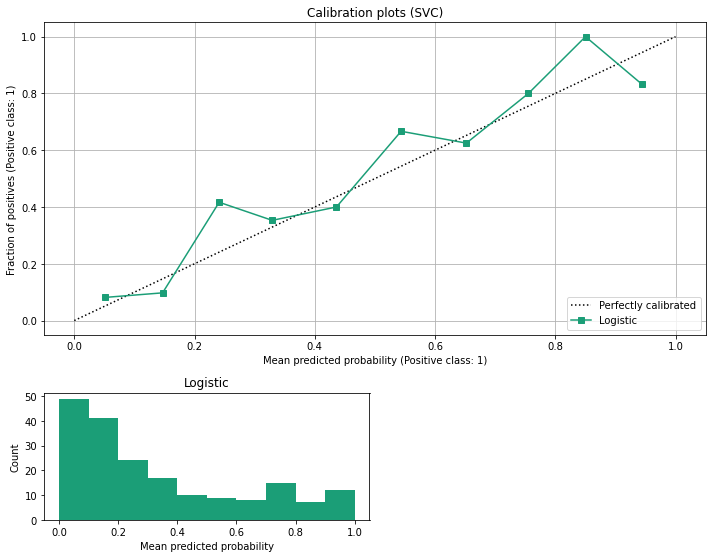

In [82]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(x_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [53]:
x1_train, x1_test, y1_train, y1_test, x2_train, x2_test, y2_train, y2_test  = return_replicates(X, y)

ValueError: Found input variables with inconsistent numbers of samples: [768, 4898]

In [25]:
datasets = data_loader()


In [26]:
X, y = datasets['diabetes']
replicates = return_replicates(X, y)


In [27]:
# for X_train, X_test, y_train, y_test in replicates:
#     print(X_train)
#     break

In [58]:
def run_simulation(dataset, n_estimators, max_samples):
    
    
    X, y = datasets[dataset]
#     pipeline = Pipeline([('scale', StandardScaler()), ('logistic', LogisticRegression(C=0.9, max_iter=1000))])
    pipeline = Pipeline([('scale', StandardScaler()), ('svc', SVC(probability=True))])

    
    replicates = return_replicates(X, y)
    for X_train, X_test, y_train, y_test in replicates:
#         print(len(X_test), len(y_test))
#         for n_estimator, max_feature in zip(n_estimators, max_features):
        for n_estimator, max_sample in itertools.product(n_estimators, max_samples):


            print(n_estimator, max_sample)
            model = BaggingClassifier(base_estimator=pipeline, n_estimators=n_estimator,
                                  max_features=1.0, max_samples=max_sample)
            X_train, X_test = np.array(X_train), np.array(X_test)
            y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
            model.fit(X_train, y_train)

            y_preds = model.predict(X_test)
            y_probs = model.predict_proba(X_test)

            probs = pd.DataFrame()
            i = 1
            for mod in model.estimators_:
                probs1 = mod.predict_proba(X_test)[:, 1] # probabilities of input being classified as 1
                probs[f'mod{i}'] = probs1
                i+=1

            var_predictions = probs.var(axis=1).ravel()

            accuracy = accuracy_score(y_test, y_preds)
            f1 = f1_score(y_test,y_preds)
            ece = expected_calibration_error(y_test, y_probs)
#             print(len(y_probs), len(var_predictions), len(y_test))
            pred_ause = ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())[0]
    
            results['dataset'].append(dataset)
            results['n_estimators'].append(n_estimator)
            results['max_samples'].append(max_sample)
            results['ause'].append(pred_ause)
            results['accuracy'].append(accuracy)
            results['ece'].append(ece)
            results['f1'].append(f1)
            print(results)

In [59]:
results = {'dataset': [],
           'n_estimators': [],
           'max_samples': [],
           'ause': [],
           'ece': [],
           'accuracy': [],
           'f1': []}

In [62]:
n_estimators = [5, 10, 20]
max_features = [0.9, 0.8, 1.0]

for dataset in datasets.keys():
    print(dataset)
    run_simulation(dataset, n_estimators, max_features)
    

diabetes
5 0.9
{'dataset': ['diabetes'], 'n_estimators': [5], 'max_samples': [0.9], 'ause': [0.3419707529746015], 'ece': [0.07134258151957378], 'accuracy': [0.75], 'f1': [0.5999999999999999]}
5 0.8
{'dataset': ['diabetes', 'diabetes'], 'n_estimators': [5, 5], 'max_samples': [0.9, 0.8], 'ause': [0.3419707529746015, 0.44866607975941797], 'ece': [0.07134258151957378, 0.11778033550191475], 'accuracy': [0.75, 0.75], 'f1': [0.5999999999999999, 0.6129032258064516]}
5 1.0
{'dataset': ['diabetes', 'diabetes', 'diabetes'], 'n_estimators': [5, 5, 5], 'max_samples': [0.9, 0.8, 1.0], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473], 'ece': [0.07134258151957378, 0.11778033550191475, 0.049282321104943926], 'accuracy': [0.75, 0.75, 0.7604166666666666], 'f1': [0.5999999999999999, 0.6129032258064516, 0.6349206349206349]}
10 0.9
{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes'], 'n_estimators': [5, 5, 5, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 0.36665448771336506, 0.4069511296957607, 0.37974092496937606, 0.38461225491534984, 0.39759224801954723, 0.28368066320550095, 0.4370619476079176, 0.3595926258969507, 0.2670715810295576], 'ece': [0.07134258151957378, 0.11778033550191475, 0.049282321104943926, 0.06485823629544062, 0.07369652469863186, 0.08637576349954357, 0.05781217460859064, 0.03246804489911294, 0.09572106533550256, 0.08584642650176662, 0.09370530263399718, 0.1218264042991265, 0.0707661129690627], 'accuracy': [0.75, 0.75, 0.7604166666666666, 0.78125, 0.8020833333333334, 0.7604166666666666, 0.7708333333333334, 0.76041666666

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 0.36665448771336506, 0.4069511296957607, 0.37974092496937606, 0.38461225491534984, 0.39759224801954723, 0.28368066320550095, 0.4370619476079176, 0.3595926258969507, 0.2670715810295576, 0.3314337063695377, 0.2198664541283985, 0.24889016561753846, 0.26093915019756825, 0.26564263017986045, 0.26448943530603536, 0.1882186571500874, 0.0993348412570039, 0.06706293144972623], 'ece': [0.07134258151957378, 

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 0.36665448771336506, 0.4069511296957607, 0.37974092496937606, 0.38461225491534984, 0.39759224801954723, 0.28368066320550095, 0.4370619476079176, 0.3595926258969507, 0.2670715810295576, 0.3314337063695377, 0.2198664541283985, 0.24889016561753846, 0.26093915019756825, 0.2656426301798604

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 0.36665448771336506, 0.4069511296957607, 0.37974092496937606, 0.38461225491534984, 0.39759224801954723, 0.28368066320550095, 0.4370619476079176, 0.3595926258969507, 0.2670715810295576, 0.331433706

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 0.36665448771336506, 0.4069511296957607, 0.37974092496937606, 0.38461225491534984, 0.39759224801954723, 0.28368066320550095, 0.

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 0.36665448771336506, 0.4069511296957607, 0.37974092496937606,

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9], 'ause': [0.3419707529746015, 0.44866607975941797, 0.4757405147960473, 0.4440328654662351, 

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0], 'ause': [0.3419707529746015, 0.44866607975941797

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8], 'ause'

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0,

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0.8, 

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5], 'max_samples': [0.9, 0.8, 1.0, 0.9, 0.8, 1.0, 0.9, 0

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10], 'max_samples': [0

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5,

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 1

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 5, 5, 5, 10, 10, 10, 20, 20,

{'dataset': ['diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'diabetes', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'ionosphere', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'red-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine', 'white-wine'], 'n_estimators': [5, 5, 5, 10, 10, 10, 20, 20, 20, 

In [63]:
simulation_runs = pd.DataFrame.from_dict(results)
simulation_runs.to_csv('simulation_runs_ensemble.csv')

In [64]:
from scipy.stats import t, f, sem
from bioinfokit.analys import stat
import statsmodels.api as sm
from statsmodels.formula.api import ols

diabetes = simulation_runs.loc[simulation_runs['dataset']=='diabetes']
ionosphere = simulation_runs.loc[simulation_runs['dataset']=='ionosphere']
red_wine = simulation_runs.loc[simulation_runs['dataset']=='red-wine']
white_wine = simulation_runs.loc[simulation_runs['dataset']=='white-wine']

diabetes['v1'] = diabetes['accuracy']+(1-diabetes['ause'])
ionosphere['v1'] = ionosphere['accuracy']+(1-ionosphere['ause'])
red_wine['v1'] = red_wine['accuracy']+(1-red_wine['ause'])
white_wine['v1'] = white_wine['accuracy']+(1-white_wine['ause'])

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_13344/2343168649.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes['v1'] = diabetes['accuracy']+(1-diabetes['ause'])
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_13344/2343168649.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ionosphere['v1'] = ionosphere['accuracy']+(1-ionosphere['ause'])
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_13344/2343168649.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Diabetes

In [81]:
diabetes.sort_values('v1', ascending=False)

,dataset,n_estimators,max_samples,ause,ece,accuracy,f1,v1
14,diabetes,10,1.0,0.219866,0.099590,0.739583,0.576271,1.519717
16,diabetes,20,0.8,0.260939,0.089307,0.760417,0.610169,1.499478
15,diabetes,20,0.9,0.248890,0.043121,0.739583,0.576271,1.490693
12,diabetes,10,0.9,0.267072,0.070766,0.739583,0.576271,1.472512
17,diabetes,20,1.0,0.265643,0.071978,0.729167,0.551724,1.463524
9,diabetes,5,0.9,0.283681,0.085846,0.739583,0.528302,1.455903
4,diabetes,10,0.8,0.366654,0.073697,0.802083,0.677966,1.435429
0,diabetes,5,0.9,0.341971,0.071343,0.750000,0.600000,1.408029
6,diabetes,20,0.9,0.379741,0.057812,0.770833,0.633333,1.391092
13,diabetes,10,0.8,0.331434,0.089981,0.708333,0.517241,1.376900


In [66]:
diabetes_model = ols('v1~n_estimators+max_samples+n_estimators*max_samples', data=diabetes).fit()
sm.stats.anova_lm(diabetes_model)

,df,sum_sq,mean_sq,F,PR(>F)
n_estimators,1.0,0.012100,0.012100,2.323650,0.149688
max_samples,1.0,0.000036,0.000036,0.006823,0.935337
n_estimators:max_samples,1.0,0.001659,0.001659,0.318595,0.581385
Residual,14.0,0.072902,0.005207,NaN,NaN


<AxesSubplot:xlabel='n_estimators', ylabel='v1'>

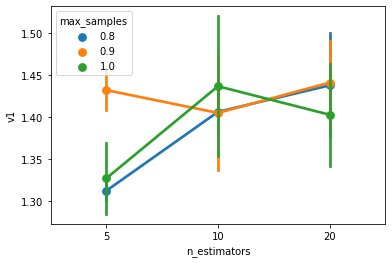

In [67]:
sns.pointplot(x='n_estimators', y='v1', hue='max_samples', data=diabetes)

In [72]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=diabetes, 
              res_var='v1', xfac_var=['n_estimators', 'max_samples'], 
              anova_model='v1~n_estimators+max_samples+n_estimators*max_samples')
res.tukey_summary.sort_values(by='p-value')

C:\Users\ADMIN\anaconda3\lib\site-packages\bioinfokit\analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
12,"(5, 0.8)","(20, 0.9)",0.128548,-0.133231,0.390327,2.519277,0.673707
13,"(5, 0.8)","(20, 0.8)",0.125297,-0.136482,0.387076,2.455548,0.697142
11,"(5, 0.8)","(10, 1.0)",0.124247,-0.137532,0.386026,2.434975,0.704708
0,"(5, 0.9)","(5, 0.8)",0.119622,-0.142157,0.381401,2.344330,0.738040
18,"(5, 1.0)","(20, 0.9)",0.113768,-0.148011,0.375547,2.229605,0.780225
19,"(5, 1.0)","(20, 0.8)",0.110516,-0.151263,0.372295,2.165876,0.803657
17,"(5, 1.0)","(10, 1.0)",0.109466,-0.152313,0.371245,2.145303,0.811221
1,"(5, 0.9)","(5, 1.0)",0.104841,-0.156938,0.366620,2.054658,0.844552
7,"(5, 0.9)","(20, 1.0)",0.029208,-0.232571,0.290987,0.572423,0.900000
33,"(20, 0.9)","(20, 0.8)",0.003252,-0.258527,0.265031,0.063729,0.900000


Ionosphere

In [69]:
ionosphere_model = ols('v1~n_estimators+max_samples+n_estimators*max_samples', data=ionosphere).fit()
sm.stats.anova_lm(ionosphere_model)

,df,sum_sq,mean_sq,F,PR(>F)
n_estimators,1.0,0.001854,0.001854,0.517699,0.483664
max_samples,1.0,0.004355,0.004355,1.215957,0.288751
n_estimators:max_samples,1.0,0.000479,0.000479,0.133635,0.720157
Residual,14.0,0.050141,0.003582,NaN,NaN


<AxesSubplot:xlabel='n_estimators', ylabel='v1'>

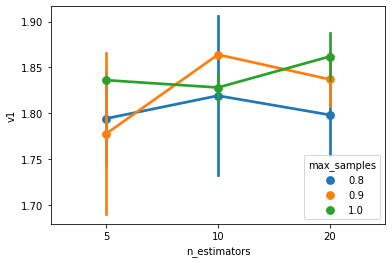

In [70]:
sns.pointplot(x='n_estimators', y='v1', hue='max_samples', data=ionosphere)

In [71]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=ionosphere, 
              res_var='v1', xfac_var=['n_estimators', 'max_samples'], 
              anova_model='v1~n_estimators+max_samples+n_estimators*max_samples')
res.tukey_summary.sort_values(by='p-value')

C:\Users\ADMIN\anaconda3\lib\site-packages\bioinfokit\analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
2,"(5, 0.9)","(10, 0.9)",0.086159,-0.130942,0.303260,2.036025,0.851403
7,"(5, 0.9)","(20, 1.0)",0.084010,-0.133091,0.301111,1.985249,0.870075
0,"(5, 0.9)","(5, 0.8)",0.016429,-0.200672,0.233530,0.388222,0.900000
21,"(10, 0.9)","(10, 0.8)",0.044829,-0.172272,0.261930,1.059358,0.900000
22,"(10, 0.9)","(10, 1.0)",0.035919,-0.181182,0.253020,0.848804,0.900000
23,"(10, 0.9)","(20, 0.9)",0.026963,-0.190138,0.244064,0.637162,0.900000
24,"(10, 0.9)","(20, 0.8)",0.065733,-0.151368,0.282834,1.553333,0.900000
25,"(10, 0.9)","(20, 1.0)",0.002149,-0.214952,0.219250,0.050777,0.900000
26,"(10, 0.8)","(10, 1.0)",0.008910,-0.208191,0.226011,0.210554,0.900000
28,"(10, 0.8)","(20, 0.8)",0.020904,-0.196197,0.238005,0.493976,0.900000


Red Wine

In [84]:
red_wine.sort_values('v1')

,dataset,n_estimators,max_samples,ause,ece,accuracy,f1,v1
47,red-wine,5,1.0,0.545672,0.074537,0.735,0.738916,1.189328
46,red-wine,5,0.8,0.537413,0.083387,0.740,0.745098,1.202587
48,red-wine,10,0.9,0.531742,0.098529,0.740,0.745098,1.208258
53,red-wine,20,1.0,0.533173,0.073798,0.745,0.748768,1.211827
51,red-wine,20,0.9,0.503158,0.090955,0.735,0.738916,1.231842
52,red-wine,20,0.8,0.488888,0.073921,0.745,0.751220,1.256112
45,red-wine,5,0.9,0.489094,0.074429,0.755,0.758621,1.265906
49,red-wine,10,0.8,0.478784,0.051420,0.750,0.757282,1.271216
50,red-wine,10,1.0,0.478284,0.091663,0.765,0.770732,1.286716
38,red-wine,5,1.0,0.293055,0.087865,0.750,0.768519,1.456945


In [73]:
red_wine_model = ols('v1~n_estimators+max_samples+n_estimators*max_samples', data=red_wine).fit()
sm.stats.anova_lm(red_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
n_estimators,1.0,0.008167,0.008167,0.305210,0.589346
max_samples,1.0,0.000287,0.000287,0.010722,0.918997
n_estimators:max_samples,1.0,0.000016,0.000016,0.000608,0.980672
Residual,14.0,0.374599,0.026757,NaN,NaN


<AxesSubplot:xlabel='n_estimators', ylabel='v1'>

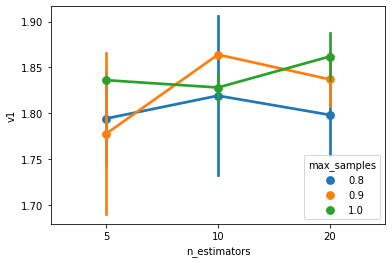

In [74]:
sns.pointplot(x='n_estimators', y='v1', hue='max_samples', data=ionosphere)

In [75]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=red_wine, 
              res_var='v1', xfac_var=['n_estimators', 'max_samples'], 
              anova_model='v1~n_estimators+max_samples+n_estimators*max_samples')
res.tukey_summary.sort_values(by='p-value')

C:\Users\ADMIN\anaconda3\lib\site-packages\bioinfokit\analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(5, 0.9)","(5, 0.8)",0.036709,-0.556691,0.630110,0.317374,0.9
20,"(5, 1.0)","(20, 1.0)",0.074477,-0.518924,0.667877,0.643897,0.9
21,"(10, 0.9)","(10, 0.8)",0.048697,-0.544704,0.642097,0.421013,0.9
22,"(10, 0.9)","(10, 1.0)",0.053822,-0.539579,0.647222,0.465321,0.9
23,"(10, 0.9)","(20, 0.9)",0.061072,-0.532328,0.654472,0.528004,0.9
24,"(10, 0.9)","(20, 0.8)",0.067190,-0.526211,0.660590,0.580897,0.9
25,"(10, 0.9)","(20, 1.0)",0.055348,-0.538053,0.648748,0.478513,0.9
19,"(5, 1.0)","(20, 0.8)",0.086319,-0.507081,0.679719,0.746281,0.9
26,"(10, 0.8)","(10, 1.0)",0.005125,-0.588275,0.598525,0.044308,0.9
28,"(10, 0.8)","(20, 0.8)",0.018493,-0.574907,0.611893,0.159884,0.9


In [76]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=red_wine, 
              res_var='v1', xfac_var=['n_estimators', 'max_samples'], 
              anova_model='v1~n_estimators+max_samples+n_estimators*max_samples')
res.tukey_summary.sort_values(by='q-value', ascending=False)

C:\Users\ADMIN\anaconda3\lib\site-packages\bioinfokit\analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
19,"(5, 1.0)","(20, 0.8)",0.086319,-0.507081,0.679719,0.746281,0.9
18,"(5, 1.0)","(20, 0.9)",0.080201,-0.513199,0.673601,0.693388,0.9
20,"(5, 1.0)","(20, 1.0)",0.074477,-0.518924,0.667877,0.643897,0.9
17,"(5, 1.0)","(10, 1.0)",0.072951,-0.520450,0.666351,0.630704,0.9
16,"(5, 1.0)","(10, 0.8)",0.067826,-0.525574,0.661226,0.586397,0.9
24,"(10, 0.9)","(20, 0.8)",0.067190,-0.526211,0.660590,0.580897,0.9
13,"(5, 0.8)","(20, 0.8)",0.063699,-0.529701,0.657099,0.550716,0.9
23,"(10, 0.9)","(20, 0.9)",0.061072,-0.532328,0.654472,0.528004,0.9
1,"(5, 0.9)","(5, 1.0)",0.059329,-0.534071,0.652730,0.512938,0.9
12,"(5, 0.8)","(20, 0.9)",0.057581,-0.535819,0.650981,0.497823,0.9


White wine

In [77]:
white_wine_model = ols('v1~n_estimators+max_samples+n_estimators*max_samples', data=white_wine).fit()
sm.stats.anova_lm(white_wine_model)

,df,sum_sq,mean_sq,F,PR(>F)
n_estimators,1.0,0.011244,0.011244,3.865759,0.069432
max_samples,1.0,0.001324,0.001324,0.455131,0.510896
n_estimators:max_samples,1.0,0.000869,0.000869,0.298604,0.593362
Residual,14.0,0.040720,0.002909,NaN,NaN


<AxesSubplot:xlabel='n_estimators', ylabel='v1'>

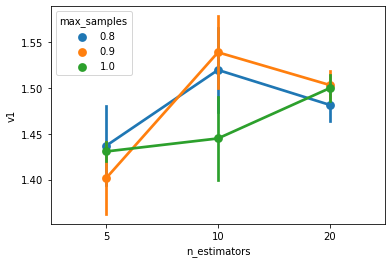

In [78]:
sns.pointplot(x='n_estimators', y='v1', hue='max_samples', data=white_wine)

In [79]:
res = stat()
res.tukey_hsd(phalpha=0.05, df=white_wine, 
              res_var='v1', xfac_var=['n_estimators', 'max_samples'], 
              anova_model='v1~n_estimators+max_samples+n_estimators*max_samples')
res.tukey_summary.sort_values(by='p-value')

C:\Users\ADMIN\anaconda3\lib\site-packages\bioinfokit\analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
2,"(5, 0.9)","(10, 0.9)",0.137175,-0.058469,0.332819,3.597088,0.290031
3,"(5, 0.9)","(10, 0.8)",0.117906,-0.077738,0.313550,3.091811,0.463227
15,"(5, 1.0)","(10, 0.9)",0.108278,-0.087366,0.303923,2.839344,0.556019
9,"(5, 0.8)","(10, 0.9)",0.101918,-0.093726,0.297562,2.672563,0.617344
5,"(5, 0.9)","(20, 0.9)",0.101519,-0.094125,0.297163,2.662095,0.621193
7,"(5, 0.9)","(20, 1.0)",0.097958,-0.097686,0.293602,2.568721,0.655530
22,"(10, 0.9)","(10, 1.0)",0.094075,-0.101569,0.289720,2.466907,0.692967
16,"(5, 1.0)","(10, 0.8)",0.089010,-0.106635,0.284654,2.334067,0.741813
10,"(5, 0.8)","(10, 0.8)",0.082649,-0.112995,0.278294,2.167286,0.803137
6,"(5, 0.9)","(20, 0.8)",0.079810,-0.115835,0.275454,2.092819,0.830521


In [80]:
res.tukey_summary.sort_values(by='q-value', ascending=False)

,group1,group2,Diff,Lower,Upper,q-value,p-value
2,"(5, 0.9)","(10, 0.9)",0.137175,-0.058469,0.332819,3.597088,0.290031
3,"(5, 0.9)","(10, 0.8)",0.117906,-0.077738,0.313550,3.091811,0.463227
15,"(5, 1.0)","(10, 0.9)",0.108278,-0.087366,0.303923,2.839344,0.556019
9,"(5, 0.8)","(10, 0.9)",0.101918,-0.093726,0.297562,2.672563,0.617344
5,"(5, 0.9)","(20, 0.9)",0.101519,-0.094125,0.297163,2.662095,0.621193
7,"(5, 0.9)","(20, 1.0)",0.097958,-0.097686,0.293602,2.568721,0.655530
22,"(10, 0.9)","(10, 1.0)",0.094075,-0.101569,0.289720,2.466907,0.692967
16,"(5, 1.0)","(10, 0.8)",0.089010,-0.106635,0.284654,2.334067,0.741813
10,"(5, 0.8)","(10, 0.8)",0.082649,-0.112995,0.278294,2.167286,0.803137
6,"(5, 0.9)","(20, 0.8)",0.079810,-0.115835,0.275454,2.092819,0.830521
